### Transductive learning (Domain Adaptation):

#### pre-processing

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transform
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import time
import torch.nn.functional as F
import os
# !pip install wget
# import wget
# !pip install requests gdown
# import gdown

In [2]:
# var init
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyper-parameter and setting
image_size = 28
batch_size = 32
channel_size = 3
lr = 1e-3
num_epochs = 5
num_classes = 10

# Data pre-processing of source and target domain
tf_source = transform.Compose([
    transform.Resize(image_size),
    transform.ToTensor(),
    transform.Normalize(mean=[0.1307,],  # Normalization as MNIST setting
                        std=[0.30,],
                        )
])

tf_target = transform.Compose([
    transform.Resize(image_size),
    transform.ToTensor(),
    transform.Normalize(mean=[0.5, 0.5, 0.5],  # Normalization as default setting
                        std=[0.5, 0.5, 0.5],
                        )
])

########################################################################################
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Dataset and dataloader source & target domain (train_set)
Ds_source = datasets.MNIST(root='/home/crueang/Chaks/AIOT/data', download=False, train=True, transform=tf_source)
Dl_source = DataLoader(Ds_source, batch_size, shuffle=True, num_workers=2)

# Download here: https://drive.google.com/drive/folders/14IgFgyHyJ3I8-VPzzA33sBF1w2E1mVVt?usp=sharing
# Mount and unzip from directory
# from google.colab import drive
# drive.mount('./drive/')
# !gdown 'https://drive.google.com/uc?id=14Cvc0SEjfOBvoCSx8LhjDLEXwg_k3y5l' -O '/home/crueang/Chaks/AIOT/data'
# !unzip '/home/crueang/Chaks/AIOT/data/MNIST_M.zip' -O '/home/crueang/Chaks/AIOT/data'
# Upload directly
# !unzip './MNIST_M.zip

Ds_target = datasets.ImageFolder(root='/home/crueang/Chaks/AIOT/data/MNIST_M/train', transform=tf_target)
Dl_target = DataLoader(Ds_target, batch_size, shuffle=True, num_workers=2)
# Ds_target_test = datasets.ImageFolder(root='./MNIST_M/test', transform=tf_target)
# Dl_target_test = DataLoader(Ds_target, batch_size, shuffle=True, num_workers=2)

def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_src_acc"], label="Train_src_acc")
    ax1.plot(history["train_tar_acc"], label="Train_tar_acc")
    ax1.legend()
    ax1.set_title("Accuracy (Src/Tar)")

    ax2.plot(history["train_loss"], label="Train_loss")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

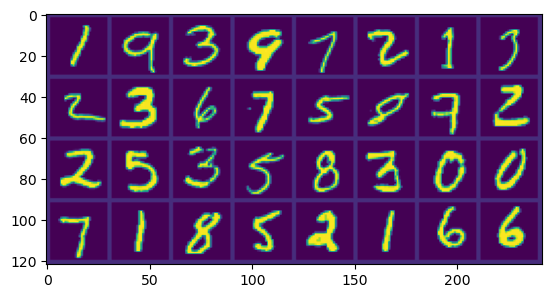

In [3]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg)
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# source
dataiter_src = iter(Dl_source)
img_src, lbl_src = next(dataiter_src)
# target
dataiter_tar = iter(Dl_target)
img_tar, lbl_tar = next(dataiter_tar)

# Create a grid from the images and show them
img_src_grid = torchvision.utils.make_grid(img_src)
matplotlib_imshow(img_src_grid, one_channel=True)
# print('  '.join(classes[labels[j]] for j in range(16)))

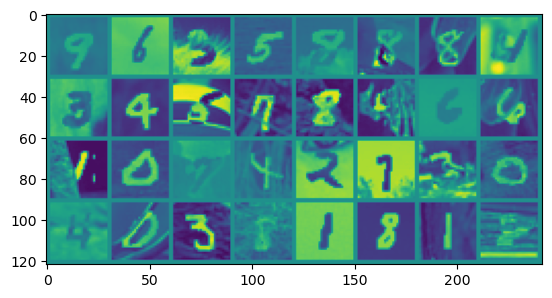

In [4]:
img_tar_grid = torchvision.utils.make_grid(img_tar)
matplotlib_imshow(img_tar_grid, one_channel=True)
# print('  '.join(classes[labels[j]] for j in range(16)))
# img_tar_grid = img_tar_grid / 2 + 0.5 # unnormalize
# plt.imshow(img_tar_grid.permute(1, 2, 0))
# plt.show()

--------------
#### DANN
Y. Ganin et al., Domain-Adversarial Training of Neural Networks (DANN), Journal of machine learning research, vol.  17, no. 59, pp. 1-35, 2015.\
Referred doc: https://arxiv.org/pdf/1505.07818.pdf\
Step taught (DA) clip reference\
Tutorial 6 - Transfer Learning & Domain Adaptation | Deep Learning on Computational Accelerators\
https://www.youtube.com/watch?v=U4ab267wl6U


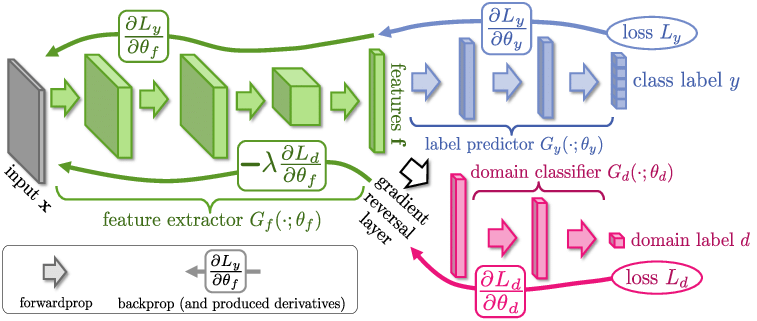

In [45]:
########################################################################################
# Network DANN()
class DANNmodel(nn.Module):
    def __init__(self, n_C=10):
        super(DANNmodel, self).__init__()

        # Encoding part (green section)
        self.feature_extractor = nn.Sequential(

            nn.Conv2d(3, 64, kernel_size = 5), # 24
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),        # 12
            nn.ReLU(),

            nn.Conv2d(64, 50, kernel_size=5),  # 8
            nn.BatchNorm2d(50),
            nn.MaxPool2d(2),        # 4
            nn.ReLU(),
            nn.Dropout2d(),
        )

        # Expand from one extractor to two extractor (classed and domain-classed)
        self.num_cnn_features = 50 * 4 * 4  # 800 flattening

        # Label classification (blue section)
        self.class_classifier = nn.Sequential(

            nn.Linear(self.num_cnn_features, 100),
            nn.BatchNorm1d(100),
            nn.Dropout(),
            nn.ReLU(),

            # nn.Linear(100, 100),
            # nn.BatchNorm1d(100),
            # nn.ReLU(),

            # output logits layer (10 classes)
            nn.Linear(100, n_C),
            nn.LogSoftmax(dim=1),
        )

        # domain classification (pink section)
        self.domain_classifier = nn.Sequential(

            nn.Linear(self.num_cnn_features, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),

            # output domain classed (2 domains)
            nn.Linear(100, 2),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x, grl_lambda=1.0):

        # Handle single-channel input by expanding (repeating) the singleton dimension
        # MNIST (grayscale, 1-channel) to 3-channel
        x = x.expand(x.data.shape[0], channel_size, image_size, image_size)

        features = self.feature_extractor(x)
        features = features.view(-1, self.num_cnn_features) #Flattening
        reverse_features = GRL.apply(features, grl_lambda)

        class_prediction = self.class_classifier(features)  #regular features classification
        domain_prediction = self.domain_classifier(reverse_features) # post-process GRL's features classification
        return  class_prediction, domain_prediction

########################################################################################

# Network model
# CNN + Gradient reversal layer (GRL) by Ganin et al., 2015
from torch.autograd import Function

class GRL(Function):        #Gradient Reversal Layer Function
    @staticmethod
    def forward(ctx, x, lamda):
        # store context for backprop
        ctx.lamda = lamda

        # forward pass is a no-op
        return x

    @staticmethod
    # upstream end and result the loss then send back to backward pass
    def backward(ctx, grad_output):
        # grad_output is dL/dx (since our forward's output was x)

        # Backward pass is just to -lamda the gradient
        # This will become the dL/dx in the rest of the network
        output = -ctx.lamda * grad_output

        # Must return number of inputs to forward()
        return output, None
    
device = 'cuda'
stored_lbs_tar = torch.empty(0, dtype=torch.float32).to(device)
stored_preds_tar = torch.empty(0, dtype=torch.float32).to(device)

if __name__ == '__main__':

    """
    # starting lambda = 0.0 because domain can't classify. anyway, when train until finished 1st head cnn_feature,
    # Increasing lambda from inserting confusing domain

    # From general idea of this paper
    # lambda is gradually changed from 0 to 1 in course of training
    # lambda = (2 / (1 + exp(-10 * p)))-1 where p is member of [0, 1] is the training progress
    """

    # network
    model = DANNmodel(n_C=num_classes).to(device)
    summary(model, input_size=(channel_size, image_size, image_size))

    # Optimizer and cost function
    optimizer = optim.Adam(model.parameters(), lr)
    # loss_fn_class = torch.nn.NLLLoss()
    # loss_fn_domain = torch.nn.NLLLoss()
    loss_fn_class = torch.nn.CrossEntropyLoss()
    loss_fn_domain = torch.nn.CrossEntropyLoss()
    # Training the same number of batches from both datasets
    max_batches = min(len(Dl_source), len(Dl_target))

    # Training
    t_0 = time.time()
    training_logs_dann = {"train_loss": [],  "train_src_acc": [], "train_tar_acc": []}
    for epoch_idx in range(num_epochs):
        train_loss, train_src_correct, train_tar_correct = 0, 0, 0
        print(f'epochs {epoch_idx+1:04d} / {num_epochs:04d}', end='\n============\n')
        Dl_source_iter = iter(Dl_source)
        Dl_target_iter = iter(Dl_target)

        for batch_idx in range(max_batches):
        # Actually: (rely on number of data in Dataloader), for i, data in enumerate(trainloader, 0):

            # zero parameters gradient to Net and optimizer
            # model.zero_grad()
            optimizer.zero_grad()

            # Training progress and GRL lambda
            p = float(batch_idx + epoch_idx * max_batches) / (num_epochs * max_batches)
            grl_lambda = 0

            # Training on source domain
            X_s, y_s = next(Dl_source_iter)
            y_s = y_s.view(batch_size)
            y_s_domain = torch.zeros(batch_size, dtype=torch.long)  # Generate source domain labels: 0, classed at domain=0

            # GPU processing source data
            X_s, y_s, y_s_domain = X_s.to(device),\
                                   y_s.to(device),\
                                   y_s_domain.to(device)

            class_prediction, domain_prediction = model(X_s, grl_lambda)
            # class_prediction, domain_prediction = class_prediction.to(device), domain_prediction.to(device)
            loss_s_label = loss_fn_class(class_prediction, y_s)                 # source classification loss
            ################### Regularizer ########################
            loss_s_domain = loss_fn_domain(domain_prediction, y_s_domain)       # source domain loss (via GRL)

            # UDA notlooking at class label
            X_t, y_t =next(Dl_target_iter)    # ignore target domain class labels
            y_t_domain = torch.ones(X_t.size(0), dtype=torch.long)   # Generate target domain labels: 1
            y_t = y_t.to(device)
            # ********************* Note

            # GPU processing target data
            X_t, y_t_domain = X_t.to(device),\
                              y_t_domain.to(device)

            _, domain_prediction = model(X_t, grl_lambda)
            ################### Regularizer ########################
            loss_t_domain = loss_fn_domain(domain_prediction, y_t_domain)       # target domain loss (via GRL)

            # loss calc.
            loss = loss_t_domain + loss_s_domain + loss_s_label
            # back-propagation (reversed grad to maximize domain loss)
            loss.backward()
            # optimization tuning
            optimizer.step()

            # #output predict from net
            with torch.no_grad():
              class_prediction_s, _ = model(X_s)
              class_prediction_t, _ = model(X_t)

            class_prediction_s = class_prediction_s.to(device)
            class_prediction_t = class_prediction_t.to(device)

            print(f'[{batch_idx+1}/{max_batches}] '
                  f'class loss: {loss_s_label.item():.4f} '
                  f'source_domain_loss: {loss_s_domain.item():.4f} '
                  f'target_domain_loss: {loss_t_domain.item():.4f} '
                  f'grl_lambda: {grl_lambda:.3f}'
                  )
            # if batch_idx == 50:
            #     print('This is just a demo, stopping...')
            #     break

            stored_lbs_tar = torch.cat((stored_lbs_tar, y_t), 0)
            _, prediction_t = torch.max(class_prediction_t, 1)
            stored_preds_tar = torch.cat((stored_preds_tar, prediction_t), 0)

            train_loss += loss.item()
            train_src_correct += (class_prediction_s.argmax(1) == y_s).float().sum().item()
            train_tar_correct += (class_prediction_t.argmax(1) == y_t).float().sum().item()

        training_logs_dann["train_src_acc"].append(train_src_correct / len(Dl_source.dataset))#.dataset))
        training_logs_dann["train_tar_acc"].append(train_tar_correct / len(Dl_target.dataset))#.dataset))
        training_logs_dann["train_loss"].append(train_loss / len(Dl_source))

        print(f'Epoch: {epoch_idx+1} || \
        Train_src_acc: {train_src_correct / len(Dl_source.dataset)}, \
        Train_tar_acc: {train_tar_correct / len(Dl_target.dataset)}, \
        Train_loss: {train_loss / len(Dl_source)}'
        )

t_end = time.time()-t_0
print(f"Time consumption for accelerated CUDA training (device:{device}): {t_end} sec")

plot_graph(training_logs_dann)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 24]           4,864
       BatchNorm2d-2           [-1, 64, 24, 24]             128
         MaxPool2d-3           [-1, 64, 12, 12]               0
              ReLU-4           [-1, 64, 12, 12]               0
            Conv2d-5             [-1, 50, 8, 8]          80,050
       BatchNorm2d-6             [-1, 50, 8, 8]             100
         MaxPool2d-7             [-1, 50, 4, 4]               0
              ReLU-8             [-1, 50, 4, 4]               0
         Dropout2d-9             [-1, 50, 4, 4]               0
           Linear-10                  [-1, 100]          80,100
      BatchNorm1d-11                  [-1, 100]             200
          Dropout-12                  [-1, 100]               0
             ReLU-13                  [-1, 100]               0
           Linear-14                   

[1/1844] class loss: 2.5381 source_domain_loss: 0.6919 target_domain_loss: 0.7609 grl_lambda: 0.000
[2/1844] class loss: 2.1853 source_domain_loss: 0.7129 target_domain_loss: 0.7375 grl_lambda: 0.000
[3/1844] class loss: 2.0238 source_domain_loss: 0.7072 target_domain_loss: 0.7290 grl_lambda: 0.000
[4/1844] class loss: 2.1282 source_domain_loss: 0.7105 target_domain_loss: 0.7308 grl_lambda: 0.000
[5/1844] class loss: 2.0094 source_domain_loss: 0.6994 target_domain_loss: 0.7176 grl_lambda: 0.000
[6/1844] class loss: 2.0853 source_domain_loss: 0.6790 target_domain_loss: 0.7309 grl_lambda: 0.000
[7/1844] class loss: 1.8856 source_domain_loss: 0.6791 target_domain_loss: 0.7312 grl_lambda: 0.000
[8/1844] class loss: 1.9469 source_domain_loss: 0.6762 target_domain_loss: 0.7582 grl_lambda: 0.000
[9/1844] class loss: 1.6276 source_domain_loss: 0.6676 target_domain_loss: 0.7467 grl_lambda: 0.000
[10/1844] class loss: 1.5923 source_domain_loss: 0.6728 target_domain_loss: 0.7589 grl_lambda: 0.000

-------
#### CORrelation ALignment (CORAL)
Sun, Baochen, Jiashi Feng, and Kate Saenko. "Correlation alignment for unsupervised domain adaptation." Domain adaptation in computer vision applications (2017): 153-171.\
Referred doc: https://link.springer.com/chapter/10.1007/978-3-319-58347-1_8

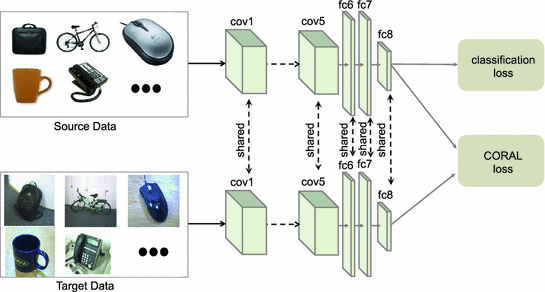\
Correlation formulated by both domain output representations\
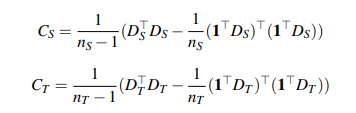\
CORAL loss\
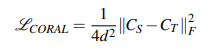

In [51]:
########################################################################################
class CorrelationAlignmentLoss(nn.Module):
    r"""The `Correlation Alignment Loss` in
    `Baochen Sun et al., Deep CORAL: Correlation Alignment for Deep Domain Adaptation (ECCV 2016) <https://arxiv.org/pdf/1607.01719.pdf>`_.
    Given source features :math:`f_S` and target features :math:`f_T`, the covariance matrices are given by
    .. math::
        C_S = \frac{1}{n_S-1}(f_S^Tf_S-\frac{1}{n_S}(\textbf{1}^Tf_S)^T(\textbf{1}^Tf_S))
    .. math::
        C_T = \frac{1}{n_T-1}(f_T^Tf_T-\frac{1}{n_T}(\textbf{1}^Tf_T)^T(\textbf{1}^Tf_T))
    where :math:`\textbf{1}` denotes a column vector with all elements equal to 1, :math:`n_S, n_T` denotes number of
    source and target samples, respectively. We use :math:`d` to denote feature dimension, use
    :math:`{\Vert\cdot\Vert}^2_F` to denote the squared matrix `Frobenius norm`. The correlation alignment loss is
    given by
    .. math::
        l_{CORAL} = \frac{1}{4d^2}\Vert C_S-C_T \Vert^2_F
    Inputs:
        - f_s (tensor): feature representations on source domain, :math:`f^s`
        - f_t (tensor): feature representations on target domain, :math:`f^t`
    Shape:
        - f_s, f_t: :math:`(N, d)` where d means the dimension of input features, :math:`N=n_S=n_T` is mini-batch size.
        - Outputs: scalar.
    """

    def __init__(self):
        super(CorrelationAlignmentLoss, self).__init__()

    def forward(self, f_s: torch.Tensor, f_t: torch.Tensor) -> torch.Tensor:
        mean_s = f_s.mean(0, keepdim=True)
        mean_t = f_t.mean(0, keepdim=True)
        cent_s = f_s - mean_s
        cent_t = f_t - mean_t
        cov_s = torch.mm(cent_s.t(), cent_s) / (len(f_s) - 1)
        cov_t = torch.mm(cent_t.t(), cent_t) / (len(f_t) - 1)

        mean_diff = (mean_s - mean_t).pow(2).mean()
        cov_diff = (cov_s - cov_t).pow(2).mean()

        return mean_diff + cov_diff

class CORALmodel(nn.Module):
    def __init__(self, n_C=10):
        super(CORALmodel, self).__init__()

        # Encoding part (green section)
        self.feature_extractor = nn.Sequential(

            nn.Conv2d(3, 64, kernel_size = 5), # 24
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),        # 12
            nn.ReLU(),

            nn.Conv2d(64, 50, kernel_size=5),  # 8
            nn.BatchNorm2d(50),
            nn.MaxPool2d(2),        # 4
            nn.ReLU(),
            nn.Dropout2d(),
        )

        # Expand from one extractor to two extractor (classed and domain-classed)
        self.num_cnn_features = 50 * 4 * 4  # 800 flattening

        # Label classification (blue section)
        self.class_classifier = nn.Sequential(

            nn.Linear(self.num_cnn_features, 100),
            nn.BatchNorm1d(100),
            nn.Dropout(),
            nn.ReLU(),

            # nn.Linear(100, 100),
            # nn.BatchNorm1d(100),
            # nn.ReLU(),

            # output logits layer (10 classes)
            nn.Linear(100, n_C),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):

        # Handle single-channel input by expanding (repeating) the singleton dimension
        # MNIST (grayscale, 1-channel) to 3-channel
        x = x.expand(x.data.shape[0], channel_size, image_size, image_size)

        features = self.feature_extractor(x)
        features = features.view(-1, self.num_cnn_features) #Flattening
        class_prediction = self.class_classifier(features)  #regular features classification
        return  class_prediction

stored_lbs_tar = torch.empty(0, dtype=torch.float32).to(device)
stored_preds_tar = torch.empty(0, dtype=torch.float32).to(device)

lambda_coral = 1
NewFile = f'W5-3_tSNE_CORAL_{lambda_coral}.png'
if __name__ == '__main__':
    # Computational graph
    # import torchviz
    # from torchviz import make_dot
    #
    # reverse_out = make_dot(loss, params=dict(w=w))
    # reverse_out.view()


    # network
    model = CORALmodel(n_C=num_classes).to(device)
    summary(model, input_size=(channel_size, image_size, image_size))

    # Optimizer and cost function
    optimizer = optim.Adam(model.parameters(), lr)
    # loss_fn_class = torch.nn.NLLLoss()
    # loss_fn_domain = torch.nn.NLLLoss()
    loss_fn_class = torch.nn.CrossEntropyLoss()
    loss_fn_domain = torch.nn.CrossEntropyLoss()
    # Training the same number of batches from both datasets
    max_batches = min(len(Dl_source), len(Dl_target))

    # Training
    t_0 = time.time()
    training_logs_coral = {"train_loss": [],  "train_src_acc": [], "train_tar_acc": []}
    for epoch_idx in range(num_epochs):
        train_loss, train_src_correct, train_tar_correct = 0, 0, 0
        print(f'epochs {epoch_idx+1:04d} / {num_epochs:04d}', end='\n============\n')
        Dl_source_iter = iter(Dl_source)
        Dl_target_iter = iter(Dl_target)

        for batch_idx in range(max_batches):
        # Actually: (rely on number of data in Dataloader), for i, data in enumerate(trainloader, 0):

            # zero parameters gradient to Net and optimizer
            # model.zero_grad()
            optimizer.zero_grad()

            # Training on source domain
            X_s, y_s = next(Dl_source_iter)

            # Training on target domain
            X_t, y_t = next(Dl_target_iter)

            if X_s.shape[0] != X_t.shape[0]:
              min_bs = min(X_s.shape[0], X_t.shape[0])
              X_s = X_s[:min_bs]
              y_s = y_s[:min_bs]
              X_t = X_t[:min_bs]
              y_t = y_t[:min_bs]

            # y_s = y_s.view(batch_size)
            # y_t = y_t.view(batch_size)

            # GPU processing source and target data
            X_s, y_s = X_s.to(device), y_s.to(device)
            X_t, y_t = X_t.to(device), y_t.to(device)

            class_pred_s = model(X_s)
            class_pred_t = model(X_t)
            loss_src = loss_fn_class(class_pred_s, y_s)                 # source classification loss

            ################### Regularizer ########################
            # Correlation alignment loss
            loss_coral = CorrelationAlignmentLoss()(class_pred_s, class_pred_t)
            ########################################################

            # back-propagation (reversed grad to maximize domain loss)
            loss = loss_src + lambda_coral * loss_coral
            loss.backward()
            # optimization tuning
            optimizer.step()

            # #output predict from net
            with torch.no_grad():
              class_prediction_s = model(X_s)
              class_prediction_t = model(X_t)

            print(f'[{batch_idx+1}/{max_batches}] '
                  f'class loss: {loss_src.item():.4f} '
                  f'CORAL_loss: {loss_coral.item():.4f} '
                  )
            # if batch_idx == 50:
            #     print('This is just a demo, stopping...')
            #     break

            stored_lbs_tar = torch.cat((stored_lbs_tar, y_t), 0)
            _, prediction_t = torch.max(class_prediction_t, 1)
            stored_preds_tar = torch.cat((stored_preds_tar, prediction_t), 0)

            train_loss += loss.item()
            train_src_correct += (class_prediction_s.argmax(1) == y_s).float().sum().item()
            train_tar_correct += (class_prediction_t.argmax(1) == y_t).float().sum().item()

        training_logs_coral["train_loss"].append(train_loss / len(Dl_source))
        training_logs_coral["train_src_acc"].append(train_src_correct / len(Dl_source.dataset))#.dataset))
        training_logs_coral["train_tar_acc"].append(train_tar_correct / len(Dl_target.dataset))#.dataset))

        print(f'Epoch: {epoch_idx+1} || \
        Train_src_acc: {train_src_correct / len(Dl_source.dataset)}, \
        Train_tar_acc: {train_tar_correct / len(Dl_target.dataset)}, \
        Train_loss: {train_loss / len(Dl_source)}'
        )

t_end = time.time()-t_0
print(f"Time consumption for accelerated CUDA training (device:{device}): {t_end} sec")

plot_graph(training_logs_coral)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 24]           4,864
       BatchNorm2d-2           [-1, 64, 24, 24]             128
         MaxPool2d-3           [-1, 64, 12, 12]               0
              ReLU-4           [-1, 64, 12, 12]               0
            Conv2d-5             [-1, 50, 8, 8]          80,050
       BatchNorm2d-6             [-1, 50, 8, 8]             100
         MaxPool2d-7             [-1, 50, 4, 4]               0
              ReLU-8             [-1, 50, 4, 4]               0
         Dropout2d-9             [-1, 50, 4, 4]               0
           Linear-10                  [-1, 100]          80,100
      BatchNorm1d-11                  [-1, 100]             200
          Dropout-12                  [-1, 100]               0
             ReLU-13                  [-1, 100]               0
           Linear-14                   

[1/1844] class loss: 2.4796 CORAL_loss: 0.0187 
[2/1844] class loss: 2.2705 CORAL_loss: 0.0208 
[3/1844] class loss: 2.1689 CORAL_loss: 0.0118 
[4/1844] class loss: 2.1094 CORAL_loss: 0.0151 
[5/1844] class loss: 2.0793 CORAL_loss: 0.0256 
[6/1844] class loss: 2.1942 CORAL_loss: 0.0221 
[7/1844] class loss: 2.1171 CORAL_loss: 0.0189 
[8/1844] class loss: 2.0259 CORAL_loss: 0.0158 
[9/1844] class loss: 1.8059 CORAL_loss: 0.0187 
[10/1844] class loss: 1.6500 CORAL_loss: 0.0270 
[11/1844] class loss: 1.6674 CORAL_loss: 0.0270 
[12/1844] class loss: 1.8271 CORAL_loss: 0.0377 
[13/1844] class loss: 1.6189 CORAL_loss: 0.0212 
[14/1844] class loss: 1.6980 CORAL_loss: 0.1021 
[15/1844] class loss: 1.6595 CORAL_loss: 0.0466 
[16/1844] class loss: 1.7476 CORAL_loss: 0.0444 
[17/1844] class loss: 1.4459 CORAL_loss: 0.0406 
[18/1844] class loss: 1.6745 CORAL_loss: 0.0380 
[19/1844] class loss: 1.5150 CORAL_loss: 0.0496 
[20/1844] class loss: 1.7126 CORAL_loss: 0.0383 
[21/1844] class loss: 1.5493 

------
#### Deep Domain Confusion (DDC) - Maximum Mean Discrepancy (MMD)

Tzeng, Eric, et al. "Deep domain confusion: Maximizing for domain invariance." arXiv preprint arXiv:1412.3474 (2014).\
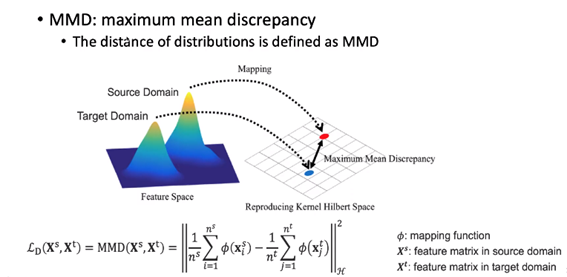

In [103]:
########################################################################################
# MMD loss
def guassian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    n_samples = int(source.size()[0])+int(target.size()[0])
    total = torch.cat([source, target], dim=0)
    total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    L2_distance = ((total0-total1)**2).sum(2)
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
    bandwidth /= kernel_mul ** (kernel_num // 2)
    bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
    kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
    return sum(kernel_val)#/len(kernel_val)

def mmdloss(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    batch_size = int(source.size()[0])
    kernels = guassian_kernel(source, target,
                              kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)
    XX = kernels[:batch_size, :batch_size]
    YY = kernels[batch_size:, batch_size:]
    XY = kernels[:batch_size, batch_size:]
    YX = kernels[batch_size:, :batch_size]
    loss = torch.mean(XX + YY - XY -YX)
    return loss

class MMDmodel(nn.Module):
    def __init__(self, n_C=10):
        super(MMDmodel, self).__init__()

        # Encoding part (green section)
        self.feature_extractor = nn.Sequential(

            nn.Conv2d(3, 64, kernel_size = 5), # 24
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),        # 12
            nn.ReLU(),

            nn.Conv2d(64, 50, kernel_size=5),  # 8
            nn.BatchNorm2d(50),
            nn.MaxPool2d(2),        # 4
            nn.ReLU(),
            nn.Dropout2d(),
        )

        # Expand from one extractor to two extractor (classed and domain-classed)
        self.num_cnn_features = 50 * 4 * 4  # 800 flattening

        # Label classification (blue section)
        self.class_classifier = nn.Sequential(

            nn.Linear(self.num_cnn_features, 100),
            nn.BatchNorm1d(100),
            nn.Dropout(),
            nn.ReLU(),

            # nn.Linear(100, 100),
            # nn.BatchNorm1d(100),
            # nn.ReLU(),

            # output logits layer (10 classes)
            nn.Linear(100, n_C),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):

        # Handle single-channel input by expanding (repeating) the singleton dimension
        # MNIST (grayscale, 1-channel) to 3-channel
        x = x.expand(x.data.shape[0], channel_size, image_size, image_size)

        features = self.feature_extractor(x)
        features = features.view(-1, self.num_cnn_features) #Flattening
        class_prediction = self.class_classifier(features)  #regular features classification
        return  class_prediction

stored_lbs_tar = torch.empty(0, dtype=torch.float32).to(device)
stored_preds_tar = torch.empty(0, dtype=torch.float32).to(device)

lambda_mmd = 1.0
NewFile = f'W5-3_tSNE_CORAL_{lambda_mmd}.png'
if __name__ == '__main__':
    # Computational graph
    # import torchviz
    # from torchviz import make_dot
    #
    # reverse_out = make_dot(loss, params=dict(w=w))
    # reverse_out.view()


    # network
    model = MMDmodel(n_C=num_classes).to(device)
    summary(model, input_size=(channel_size, image_size, image_size))

    # Optimizer and cost function
    optimizer = optim.Adam(model.parameters(), lr)
    # loss_fn_class = torch.nn.NLLLoss()
    # loss_fn_domain = torch.nn.NLLLoss()
    loss_fn_class = torch.nn.CrossEntropyLoss()
    loss_fn_domain = torch.nn.CrossEntropyLoss()
    # Training the same number of batches from both datasets
    max_batches = min(len(Dl_source), len(Dl_target))

    # Training
    t_0 = time.time()
    training_logs_mmd = {"train_loss": [],  "train_src_acc": [], "train_tar_acc": []}
    for epoch_idx in range(num_epochs):
        train_loss, train_src_correct, train_tar_correct = 0, 0, 0
        print(f'epochs {epoch_idx+1:04d} / {num_epochs:04d}', end='\n============\n')
        Dl_source_iter = iter(Dl_source)
        Dl_target_iter = iter(Dl_target)

        for batch_idx in range(max_batches):
        # Actually: (rely on number of data in Dataloader), for i, data in enumerate(trainloader, 0):

            # zero parameters gradient to Net and optimizer
            # model.zero_grad()
            optimizer.zero_grad()

            # Training on source domain
            X_s, y_s = next(Dl_source_iter)

            # Training on target domain
            X_t, y_t = next(Dl_target_iter)

            if X_s.shape[0] != X_t.shape[0]:
              min_bs = min(X_s.shape[0], X_t.shape[0])
              X_s = X_s[:min_bs]
              y_s = y_s[:min_bs]
              X_t = X_t[:min_bs]
              y_t = y_t[:min_bs]

            # y_s = y_s.view(batch_size)
            # y_t = y_t.view(batch_size)

            # GPU processing source and target data
            X_s, y_s = X_s.to(device), y_s.to(device)
            X_t, y_t = X_t.to(device), y_t.to(device)

            class_pred_s = model(X_s)
            class_pred_t = model(X_t)
            cls_loss = loss_fn_class(class_pred_s, y_s)                 # source classification loss

            ################### Regularizer ########################
            # Correlation alignment loss
            mmd_loss = mmdloss(class_pred_s, class_pred_t)#, kernel_mul=2.0, kernel_num=5)
            ########################################################

            # back-propagation (reversed grad to maximize domain loss)
            loss = cls_loss + lambda_mmd * mmd_loss
            loss.backward()
            # optimization tuning
            optimizer.step()

            # #output predict from net
            with torch.no_grad():
              class_prediction_s = model(X_s)
              class_prediction_t = model(X_t)

            print(f'[{batch_idx+1}/{max_batches}] '
                  f'class loss: {loss.item():.4f} '
                  f'MMD_loss: {loss_coral.item():.4f} '
                  )
            # if batch_idx == 50:
            #     print('This is just a demo, stopping...')
            #     break
            
            stored_lbs_tar = torch.cat((stored_lbs_tar, y_t), 0)
            _, prediction_t = torch.max(class_prediction_t, 1)
            stored_preds_tar = torch.cat((stored_preds_tar, prediction_t), 0)

            train_loss += loss.item()
            train_src_correct += (class_prediction_s.argmax(1) == y_s).float().sum().item()
            train_tar_correct += (class_prediction_t.argmax(1) == y_t).float().sum().item()

        training_logs_mmd["train_loss"].append(train_loss / len(Dl_source))
        training_logs_mmd["train_src_acc"].append(train_src_correct / len(Dl_source.dataset))#.dataset))
        training_logs_mmd["train_tar_acc"].append(train_tar_correct / len(Dl_target.dataset))#.dataset))

        print(f'Epoch: {epoch_idx+1} || \
        Train_src_acc: {train_src_correct / len(Dl_source.dataset)}, \
        Train_tar_acc: {train_tar_correct / len(Dl_target.dataset)}, \
        Train_loss: {train_loss / len(Dl_source)}'
        )

t_end = time.time()-t_0
print(f"Time consumption for accelerated CUDA training (device:{device}): {t_end} sec")

plot_graph(training_logs_mmd)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 24]           4,864
       BatchNorm2d-2           [-1, 64, 24, 24]             128
         MaxPool2d-3           [-1, 64, 12, 12]               0
              ReLU-4           [-1, 64, 12, 12]               0
            Conv2d-5             [-1, 50, 8, 8]          80,050
       BatchNorm2d-6             [-1, 50, 8, 8]             100
         MaxPool2d-7             [-1, 50, 4, 4]               0
              ReLU-8             [-1, 50, 4, 4]               0
         Dropout2d-9             [-1, 50, 4, 4]               0
           Linear-10                  [-1, 100]          80,100
      BatchNorm1d-11                  [-1, 100]             200
          Dropout-12                  [-1, 100]               0
             ReLU-13                  [-1, 100]               0
           Linear-14                   

-------------
#### Source-Only

In [111]:
########################################################################################
class SOmodel(nn.Module):
    def __init__(self, n_C=10):
        super(SOmodel, self).__init__()

        # Encoding part (green section)
        self.feature_extractor = nn.Sequential(

            nn.Conv2d(3, 64, kernel_size = 5), # 24
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),        # 12
            nn.ReLU(),

            nn.Conv2d(64, 50, kernel_size=5),  # 8
            nn.BatchNorm2d(50),
            nn.MaxPool2d(2),        # 4
            nn.ReLU(),
            nn.Dropout2d(),
        )

        # Expand from one extractor to two extractor (classed and domain-classed)
        self.num_cnn_features = 50 * 4 * 4  # 800 flattening

        # Label classification (blue section)
        self.class_classifier = nn.Sequential(

            nn.Linear(self.num_cnn_features, 100),
            nn.BatchNorm1d(100),
            nn.Dropout(),
            nn.ReLU(),

            # nn.Linear(100, 100),
            # nn.BatchNorm1d(100),
            # nn.ReLU(),

            # output logits layer (10 classes)
            nn.Linear(100, n_C),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):

        # Handle single-channel input by expanding (repeating) the singleton dimension
        # MNIST (grayscale, 1-channel) to 3-channel
        x = x.expand(x.data.shape[0], channel_size, image_size, image_size)

        features = self.feature_extractor(x)
        features = features.view(-1, self.num_cnn_features) #Flattening
        class_prediction = self.class_classifier(features)  #regular features classification
        return  class_prediction

stored_lbs_tar = torch.empty(0, dtype=torch.float32).to(device)
stored_preds_tar = torch.empty(0, dtype=torch.float32).to(device)

if __name__ == '__main__':

    # Computational graph
    # import torchviz
    # from torchviz import make_dot
    #
    # reverse_out = make_dot(loss, params=dict(w=w))
    # reverse_out.view()


    # network
    model = SOmodel(n_C=num_classes).to(device)
    summary(model, input_size=(channel_size, image_size, image_size))

    # Optimizer and cost function
    optimizer = optim.Adam(model.parameters(), lr)
    # loss_fn_class = torch.nn.NLLLoss()
    # loss_fn_domain = torch.nn.NLLLoss()
    loss_fn_class = torch.nn.CrossEntropyLoss()
    loss_fn_domain = torch.nn.CrossEntropyLoss()
    # Training the same number of batches from both datasets
    max_batches = min(len(Dl_source), len(Dl_target))

    # Training
    t_0 = time.time()
    training_logs_so = {"train_loss": [],  "train_src_acc": [], "train_tar_acc": []}
    for epoch_idx in range(num_epochs):
        train_loss, train_src_correct, train_tar_correct = 0, 0, 0
        print(f'epochs {epoch_idx+1:04d} / {num_epochs:04d}', end='\n============\n')
        Dl_source_iter = iter(Dl_source)
        Dl_target_iter = iter(Dl_target)

        for batch_idx in range(max_batches):
        # Actually: (rely on number of data in Dataloader), for i, data in enumerate(trainloader, 0):

            # zero parameters gradient to Net and optimizer
            # model.zero_grad()
            optimizer.zero_grad()

            # Training on source domain
            X_s, y_s = next(Dl_source_iter)
            # y_s = y_s.view(batch_size)

            X_t, y_t = next(Dl_target_iter)
            # y_t = y_t.view(batch_size)

            if X_s.shape[0] != X_t.shape[0]:
              min_bs = min(X_s.shape[0], X_t.shape[0])
              X_s = X_s[:min_bs]
              y_s = y_s[:min_bs]
              X_t = X_t[:min_bs]
              y_t = y_t[:min_bs]

            # GPU processing source data
            X_s, y_s = X_s.to(device), y_s.to(device)
            X_t, y_t = X_t.to(device), y_t.to(device)

            class_prediction = model(X_s)
            loss = loss_fn_class(class_prediction, y_s)                 # source classification loss

            # back-propagation (reversed grad to maximize domain loss)
            loss.backward()
            # optimization tuning
            optimizer.step()

            # #output predict from net
            with torch.no_grad():
              class_prediction_s = model(X_s)
              class_prediction_t = model(X_t)

            print(f'[{batch_idx+1}/{max_batches}] '
                  f'class loss: {loss.item():.4f} '
                  )
            # if batch_idx == 50:
            #     print('This is just a demo, stopping...')
            #     break

            class_prediction_s = class_prediction_s.to(device)
            class_prediction_t = class_prediction_t.to(device)

            # store vec of target
            stored_lbs_tar = torch.cat((stored_lbs_tar, y_t), 0)
            _, prediction_t = torch.max(class_prediction_t, 1)
            stored_preds_tar = torch.cat((stored_preds_tar, prediction_t), 0)

            train_loss += loss.item()
            train_src_correct += (class_prediction_s.argmax(1) == y_s).float().sum().item()
            train_tar_correct += (class_prediction_t.argmax(1) == y_t).float().sum().item()

        training_logs_so["train_loss"].append(train_loss / len(Dl_source))
        training_logs_so["train_src_acc"].append(train_src_correct / len(Dl_source.dataset))#.dataset))
        training_logs_so["train_tar_acc"].append(train_tar_correct / len(Dl_target.dataset))#.dataset))

        print(f'Epoch: {epoch_idx+1} || \
        Train_src_acc: {train_src_correct / len(Dl_source.dataset)}, \
        Train_tar_acc: {train_tar_correct / len(Dl_target.dataset)}, \
        Train_loss: {train_loss / len(Dl_source)}'
        )

t_end = time.time()-t_0
print(f"Time consumption for accelerated CUDA training (device:{device}): {t_end} sec")

plot_graph(training_logs_so)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 24]           4,864
       BatchNorm2d-2           [-1, 64, 24, 24]             128
         MaxPool2d-3           [-1, 64, 12, 12]               0
              ReLU-4           [-1, 64, 12, 12]               0
            Conv2d-5             [-1, 50, 8, 8]          80,050
       BatchNorm2d-6             [-1, 50, 8, 8]             100
         MaxPool2d-7             [-1, 50, 4, 4]               0
              ReLU-8             [-1, 50, 4, 4]               0
         Dropout2d-9             [-1, 50, 4, 4]               0
           Linear-10                  [-1, 100]          80,100
      BatchNorm1d-11                  [-1, 100]             200
          Dropout-12                  [-1, 100]               0
             ReLU-13                  [-1, 100]               0
           Linear-14                   

[1/1844] class loss: 2.6122 
[2/1844] class loss: 2.2547 
[3/1844] class loss: 2.2853 
[4/1844] class loss: 2.0642 
[5/1844] class loss: 2.1410 
[6/1844] class loss: 2.0973 
[7/1844] class loss: 1.7900 
[8/1844] class loss: 1.8569 
[9/1844] class loss: 1.8601 
[10/1844] class loss: 2.0805 
[11/1844] class loss: 1.7151 
[12/1844] class loss: 1.8284 
[13/1844] class loss: 1.8999 
[14/1844] class loss: 1.7005 
[15/1844] class loss: 1.5617 
[16/1844] class loss: 1.7400 
[17/1844] class loss: 1.4300 
[18/1844] class loss: 1.5421 
[19/1844] class loss: 1.5779 
[20/1844] class loss: 1.6431 
[21/1844] class loss: 1.4820 
[22/1844] class loss: 1.2662 
[23/1844] class loss: 1.5361 
[24/1844] class loss: 1.3967 
[25/1844] class loss: 1.5756 
[26/1844] class loss: 1.2643 
[27/1844] class loss: 1.4476 
[28/1844] class loss: 1.3653 
[29/1844] class loss: 1.4792 
[30/1844] class loss: 1.2545 
[31/1844] class loss: 1.2288 
[32/1844] class loss: 1.2078 
[33/1844] class loss: 1.2960 
[34/1844] class los

---------------
# Quantitative, Qualitative, and Visualization Measures
- t-SNE (New)
- A-distance (Inter-domain distribution distances) (New)
- NMI/RI score (New)
- Precision, Recall, F1-score, Confusion Matrix

In [17]:
# @title Function
# https://github.com/fyse-nassar/Malware-Family-Classification/blob/master/Malware%20Opcode%20Ngrams%20Generator.ipynb
# https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html

import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from typing import Optional, List
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import tqdm
import os.path as osp
import matplotlib
matplotlib.use('Agg')
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.colors as col


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    #plt.xticks(tick_marks, classes, rotation=45)    #office-31
    plt.xticks(tick_marks, classes, rotation=20, fontsize=12)    #office-home
    plt.yticks(tick_marks, classes, fontsize=12)

    if normalize==True:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis]+1)
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    # print(cm)

    formated = '.2f' if normalize==True else 'd'
    #---manual---
    thresh = cm.max() / 2.
    #thresh > 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], formated),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #---sns---
    #df_cm = pd.DataFrame(cm, classes, classes)
    #sns.heatmap(df_cm, annot=True, fmt=formated, cmap=cmap)

    plt.gcf().set_size_inches(8, 6)
    plt.ylabel('Ground Truth')
    plt.xlabel('Prediction')
    plt.margins(2,2)
    plt.tight_layout()



"""
  Args: Collect feature
  Ref: https://github.com/zhjscut/Bridging_UDA_SSL/blob/e0be6742f1203bb983261e3e1e57d34e1e03299d/common/utils/analysis/__init__.py#L7
"""

def collect_feature(data_loader: DataLoader, feature_extractor: nn.Module,
                                   device: torch.device, max_num_features=None) -> torch.Tensor:
    """
    Fetch data from `data_loader`, and then use `feature_extractor` to collect features
    Args:
        data_loader (torch.utils.data.DataLoader): Data loader.
        feature_extractor (torch.nn.Module): A feature extractor.
        device (torch.device)
        max_num_features (int): The max number of features to return
    Returns:
        Features in shape (min(len(data_loader), max_num_features), :math:`|\mathcal{F}|`).
    """
    feature_extractor.eval()
    all_features = []
    all_labels = []
    with torch.no_grad():
        for i, (images, target) in enumerate(tqdm.tqdm(data_loader)):
            images = images.to(device)
            features = feature_extractor(images)
            if isinstance(features, tuple):
                # Check if it's a tuple (common when using certain pre-trained models)
                # You may want to select the feature tensor you need from the tuple
                # For example, if the feature tensor is the first element of the tuple:
                feature_tensor = features[0]
                feature_tensor = feature_tensor.to(device)  # Move the tensor to CPU
            else:
                feature_tensor = features.to(device)  # Move the tensor to CPU

            all_features.append(feature_tensor)
            all_labels.append(target)

    return torch.cat(all_features, dim=0),\
        torch.cat(all_labels, dim=0) # Concatenate the list of feature tensors

    #        all_features.append(features)
    #        if max_num_features is not None and i >= max_num_features:
    #            break
    #return torch.cat(all_features, dim=0)


# ref https://github.com/zhjscut/Bridging_UDA_SSL/blob/e0be6742f1203bb983261e3e1e57d34e1e03299d/common/utils/analysis/__init__.py#L7

def visualize(source_feature: torch.Tensor, target_feature: torch.Tensor,
              filename: str, source_color='r', target_color='b'):
    """
    Visualize features from different domains using t-SNE.
    Args:
        source_feature (tensor): features from source domain in shape :math:`(minibatch, F)`
        target_feature (tensor): features from target domain in shape :math:`(minibatch, F)`
        filename (str): the file name to save t-SNE
        source_color (str): the color of the source features. Default: 'r'
        target_color (str): the color of the target features. Default: 'b'
    """
    source_feature = source_feature.cpu().numpy()
    target_feature = target_feature.cpu().numpy()
    features = np.concatenate([source_feature, target_feature], axis=0)

    # map features to 2-d using TSNE
    X_tsne = TSNE(n_components=2, random_state=33).fit_transform(features)

    # domain labels, 1 represents source while 0 represents target
    domains = np.concatenate((np.ones(len(source_feature)), np.zeros(len(target_feature))))

    # visualize using matplotlib
    plt.figure(figsize=(10, 10))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=domains, cmap=col.ListedColormap([source_color, target_color]), s=20)  #default: s=2
    plt.savefig(filename)


"""
  Arg: t-SNE for class clustering visualization
"""

def visualize_class_n_domain(source_feature: torch.Tensor,
                             target_feature: torch.Tensor,
                             source_labels: torch.Tensor,
                             target_labels: torch.Tensor,
                             filename: str,
                             source_color='r',
                             target_color='b'):
    """
    Visualize features from different domains using t-SNE.
    Args:
        source_feature (tensor): features from source domain in shape :math:`(minibatch, F)`
        target_feature (tensor): features from target domain in shape :math:`(minibatch, F)`
        source_labels (tensor): class labels for source domain features
        target_labels (tensor): class labels for target domain features
        filename (str): the file name to save t-SNE
        source_color (str): the color of the source features. Default: 'r'
        target_color (str): the color of the target features. Default: 'b'
    """
    source_feature = source_feature.cpu().numpy()
    target_feature = target_feature.cpu().numpy()
    source_labels = source_labels.cpu().numpy()
    target_labels = target_labels.cpu().numpy()

    # Combine features and labels
    features = np.concatenate([source_feature, target_feature], axis=0)
    labels = np.concatenate([source_labels, target_labels], axis=0)
    domains = np.concatenate((np.ones(len(source_feature)), np.zeros(len(target_feature))))

    # Map features to 2-D using t-SNE
    X_tsne = TSNE(n_components=2, random_state=33).fit_transform(features)

    # Visualize using matplotlib
    plt.figure(figsize=(10, 10))

    # Get unique class labels
    unique_labels = np.unique(labels)

    # Create a color map for classes
    #cmap = plt.get_cmap('tab20', len(unique_labels))
    cmap_s = plt.get_cmap('nipy_spectral', len(unique_labels))
    cmap_r = plt.get_cmap('gist_rainbow', len(unique_labels))

    # Plot data points for each class and domain
    for label in unique_labels:
        for domain in [0, 1]:
            mask = (labels == label) & (domains == domain)
            plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=cmap_s(label), s=10,
                        #label=f"Class {label}, Domain {domain}",
                        )

    plt.legend()
    plt.savefig(filename)

# Example usage
# visualize(source_feature, target_feature, source_labels, target_labels, 'tsne_plot.png')





from torch.utils.data import TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import SGD

"""
  Args: A-distance computation
  Ref: https://github.com/zhjscut/Bridging_UDA_SSL/blob/e0be6742f1203bb983261e3e1e57d34e1e03299d/common/utils/analysis/a_distance.py
"""

def binary_accuracy(output: torch.Tensor, target: torch.Tensor) -> float:
    """Computes the accuracy for binary classification"""
    with torch.no_grad():
        batch_size = target.size(0)
        pred = (output >= 0.5).float().t().view(-1)
        correct = pred.eq(target.view(-1)).float().sum()
        correct.mul_(100. / batch_size)
        return correct

class ANet(nn.Module):
    def __init__(self, in_feature):
        super(ANet, self).__init__()
        self.layer = nn.Linear(in_feature, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer(x)
        x = self.sigmoid(x)
        return x


def Adist_calculate(source_feature: torch.Tensor, target_feature: torch.Tensor,
              device, progress=True, training_epochs=10):
    """
    Calculate the :math:`\mathcal{A}`-distance, which is a measure for distribution discrepancy.
    The definition is :math:`dist_\mathcal{A} = 2 (1-2\epsilon)`, where :math:`\epsilon` is the
    test error of a classifier trained to discriminate the source from the target.
    Args:
        source_feature (tensor): features from source domain in shape :math:`(minibatch, F)`
        target_feature (tensor): features from target domain in shape :math:`(minibatch, F)`
        device (torch.device)
        progress (bool): if True, displays a the progress of training A-Net
        training_epochs (int): the number of epochs when training the classifier
    Returns:
        :math:`\mathcal{A}`-distance
    """
    source_label = torch.ones((source_feature.shape[0], 1)).to(device)
    target_label = torch.zeros((target_feature.shape[0], 1)).to(device)
    feature = torch.cat([source_feature, target_feature], dim=0).to(device)
    label = torch.cat([source_label, target_label], dim=0).to(device)

    dataset = TensorDataset(feature, label)
    length = len(dataset)
    train_size = int(0.8 * length)
    val_size = length - train_size

    # Specify a random generator for CUDA
    generator = torch.Generator(device='cpu')

    train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size], generator)
    train_loader = DataLoader(train_set, batch_size=2, shuffle=True, generator=generator)
    val_loader = DataLoader(val_set, batch_size=8, shuffle=False, generator=generator)

    anet = ANet(feature.shape[1]).to(device)
    optimizer = SGD(anet.parameters(), lr=0.01)
    a_distance = 2.0
    for epoch in range(training_epochs):
        anet.train()
        for (x, label) in train_loader:
            x = x.to(device)
            label = label.to(device)
            anet.zero_grad()
            y = anet(x)
            y = y.to(device)
            loss = F.binary_cross_entropy(y, label)
            loss.backward()
            optimizer.step()

        anet.eval()
        meter = AverageMeter("accuracy", ":4.2f")
        with torch.no_grad():
            for (x, label) in val_loader:
                x = x.to(device)
                label = label.to(device)
                y = anet(x)
                y = y.to(device)
                acc = binary_accuracy(y, label)
                meter.update(acc, x.shape[0])
        error = 1 - meter.avg / 100
        a_distance = 2 * (1 - 2 * error)
        if progress:
            print("epoch {} accuracy: {} A-dist: {}".format(epoch, meter.avg, a_distance))

    return a_distance




class AverageMeter(object):
    r"""Computes and stores the average and current value.
    Examples::
        >>> # Initialize a meter to record loss
        >>> losses = AverageMeter()
        >>> # Update meter after every minibatch update
        >>> losses.update(loss_value, batch_size)
    """
    def __init__(self, name: str, fmt: Optional[str] = ':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        if self.count > 0:
            self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class AverageMeterDict(object):
    def __init__(self, names: List, fmt: Optional[str] = ':f'):
        self.dict = {
            name: AverageMeter(name, fmt) for name in names
        }

    def reset(self):
        for meter in self.dict.values():
            meter.reset()

    def update(self, accuracies, n=1):
        for name, acc in accuracies.items():
            self.dict[name].update(acc, n)

    def average(self):
        return {
            name: meter.avg for name, meter in self.dict.items()
        }

    def __getitem__(self, item):
        return self.dict[item]


class Meter(object):
    """Computes and stores the current value."""
    def __init__(self, name: str, fmt: Optional[str] = ':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0

    def update(self, val):
        self.val = val

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '}'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [7]:
def get_labels_predictions(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_predictions = []

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Get the predicted class
            _, predictions = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    return all_labels, all_predictions

In [52]:
###########################################################################################
# --- Confusion matrix, F1-score, precision, recall, NMI/RI scores
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, normalized_mutual_info_score, adjusted_rand_score#, f1_score
# Class labels
pos_labels = np.arange(10)
lb_classes = ('0', '1', '2', '3', '4', '5', '6' ,'7', '8', '9')
device = 'cuda'

lb = stored_lbs_tar.cpu()
prd = stored_preds_tar.cpu()

#---confusion matrix
cm_target = confusion_matrix(y_true=lb,
                            y_pred=prd,
                            labels=pos_labels,
                            normalize='true',
                            )
plt.figure()
plt.rcParams.update({'font.size': 10, 'figure.figsize': (2,2)})
plot_confusion_matrix(cm_target,
                        classes=lb_classes,
                        normalize=True,
                        title='Conf. Mat. w.r.t. CIFAR-10 ds',
                        cmap=plt.cm.binary #Blues_r
                        )    #Blues_r = off-white diagonal
#---F1-score/Precision/Recall scores
print("Precision/Recall/F-beta score:", precision_recall_fscore_support(lb, prd, average='weighted', zero_division=0,
                                          beta=1.0)) #labels=label_classes))
#---Normalized Mutual Information (NMI) score
nmi_score = normalized_mutual_info_score(labels_true=lb,
                                        labels_pred=prd,
                                        average_method='arithmetic',
                                        )
#---Rand Index (RI) score
ri_score = adjusted_rand_score(labels_true=lb,
                                labels_pred=prd,
                                )
print(f"NMI score: {nmi_score}, RI score: {ri_score}")


source_feature, s_labels = collect_feature(Dl_source, model, device)
target_feature, t_labels = collect_feature(Dl_target, model, device)

# --- Calculate A-distance, which is a measure for distribution discrepancy
A_distance = Adist_calculate(source_feature, target_feature, device, training_epochs=5)
print("A-distance =", A_distance)

# --- plot t-SNE
tSNE_filename = osp.join('/home/crueang/jira/output/', NewFile)
sample_size = 1000
source_indices = np.random.choice(len(source_feature), sample_size, replace=False)
target_indices = np.random.choice(len(target_feature), sample_size, replace=False)
sampled_source_feature = source_feature[source_indices]
sampled_target_feature = target_feature[target_indices]
sampled_s_labels = s_labels[source_indices]
sampled_t_labels = t_labels[target_indices]
visualize_class_n_domain(sampled_source_feature, sampled_target_feature, sampled_s_labels, sampled_t_labels, tSNE_filename)    # two-domain multi-class rep
print("Saving t-SNE to", tSNE_filename)

Precision/Recall/F-beta score: (0.6752867020306981, 0.65533126557177, 0.6593999988851157, None)
NMI score: 0.41808483034244687, RI score: 0.37496283302710903


100%|██████████| 1844/1844 [00:23<00:00, 77.02it/s]


epoch 0 accuracy: 91.18944549560547 A-dist: 1.6475777626037598
epoch 1 accuracy: 91.6011962890625 A-dist: 1.6640477180480957
epoch 2 accuracy: 93.81539154052734 A-dist: 1.7526156902313232
epoch 3 accuracy: 93.60951232910156 A-dist: 1.7443804740905762
epoch 4 accuracy: 89.3113784790039 A-dist: 1.5724551677703857
A-distance = tensor(1.5725, device='cuda:0')


/tmp/ipykernel_2193664/2418694441.py:187: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=cmap_s(label), s=10,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saving t-SNE to /home/crueang/jira/output/W5-3_tSNE_CORAL_1.png


(10, 10)


# Example: Source-Only t-SNE visualization plot
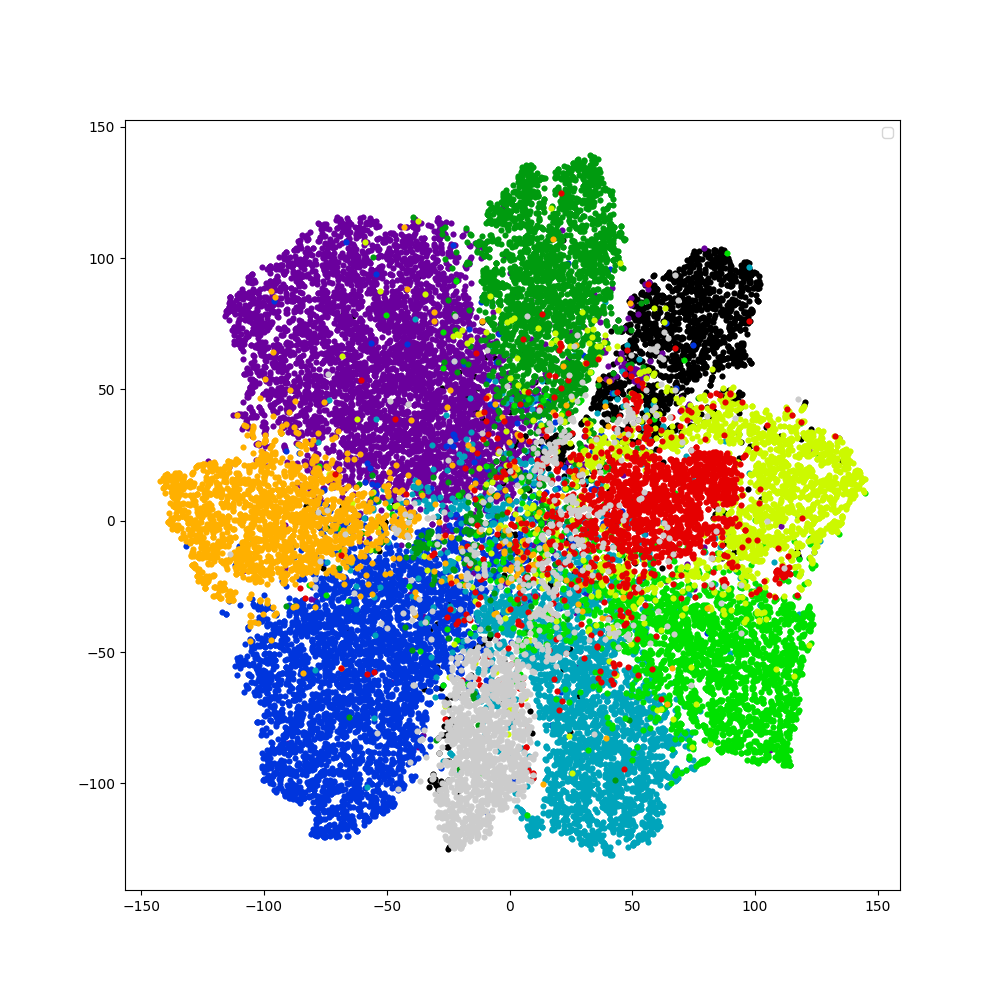

-----
Others?\
There are several beyond techniques out of shown above, such as Log-CORAL, MK-MMD, JAN, CDAN, MCC, MDD, Robust-CORAL, High-Order CORAL, or newer

----
# Homework

ทำการปรับค่าตามใน array ข้างใต้ใช้ batch size เท่ากันที่ 32 หรือ ุ64 เทรนบน T4 GPU

*    เพื่อควบคุมความสามารถการปรับปรุงของ CORAL และ MMD
```
lambda_weights = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0] #<---- 6 ค่าใน array
```

*   เพื่อควบคุมความสามารถการปรับปรุงของ DANN
```
grl_weights = [0, (2 / (1 + np.exp(-10 * p)))-1, 1] #<---- 3 ค่าใน array
```


เปรียบเทียบและวิเคราะห์ผล การเรียนรู้แบบ source-only และเทคนิค DA แบบอื่น ๆ ที่ให้มา (MMD, CORAL, DDC, etc.) และอภิปรายผลเชิง
- Quantitative (target_test_acc, target_test_loss, precision, recall, F1-score, confusion matrix, etc.)
- Qualitative (NMI/RI score, A-distance)
- Visualization (plot of loss/acc, t-SNE) results